In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [18]:
# 1.cargar df

# 2.preprocesamiento de loan_status
#eliminar 'current' y simplificar el resto de los estados.
df_limpio = df_limpio[~df_limpio['loan_status'].isin(['Current'])]

#columna target (1:no pagado, 0:pagado)
status_mapping = {
    'Fully Paid': 0,
    'Does not meet the credit policy: Fully Paid': 0,
    'Charged Off': 1,
    'Does not meet the credit policy: Charged Off': 1,
    'Late (31-120 days)': 1,
    'Late (16-30 days)': 1,
    'Default': 1
}
df_limpio['loan_status_target'] = df_limpio['loan_status'].map(status_mapping)

In [19]:
# 3.eliminar filas donde la columna target sea NaN
df_limpio = df_limpio.dropna(subset=['loan_status_target'])

In [21]:
# 4.separar X e y
X = df_limpio.drop(columns=['loan_status', 'loan_status_target'])
y = df_limpio['loan_status_target']

In [22]:
# 5.eliminar columnas vacías
X = X.dropna(axis=1, how='all')

# separar columnas numéricas y categóricas
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

In [23]:
# 6.convertir columnas categóricas a cadenas
X[cat_cols] = X[cat_cols].astype(str)

# imputación de valores faltantes
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

# aplicar imputadores solo en columnas que tengan al menos un valor no nulo
X[num_cols] = num_imputer.fit_transform(X[num_cols])
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

In [24]:
# 7.escalado logarítmico para variables numéricas(para intentar qu elos datos se asemejen lo maximo posible a una distribucion normal)
#no quitamos outliers porque pueden identificar claros morosos
#aplicamos logaritmo solo a columnas que sean estrictamente positivas
X[num_cols] = np.log1p(X[num_cols])

In [25]:
# 8. 
encoder = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'), X[cat_cols].columns)
], remainder='passthrough')

In [29]:
# 9. Escalado de variables numéricas
scaler = StandardScaler(with_mean=False)

In [30]:
# 10.El desbalance de clases es común en problemas de morosidad, donde la mayoría de los préstamos están pagados. Usamos undersampling para reducir la cantidad de ejemplos de la clase mayoritaria (pagados).
undersampler = RandomUnderSampler(sampling_strategy=1)

In [31]:
# 11.train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

preprocessor = Pipeline(steps=[
    ('encoder', encoder),
    ('scaler', scaler)
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

#undersampling en el conjunto de entrenamiento
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

In [32]:
# 12.entrenar el modelo
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97      8699
         1.0       0.82      0.96      0.89      2362

    accuracy                           0.95     11061
   macro avg       0.91      0.95      0.93     11061
weighted avg       0.95      0.95      0.95     11061

ROC-AUC Score: 0.9937445484843119


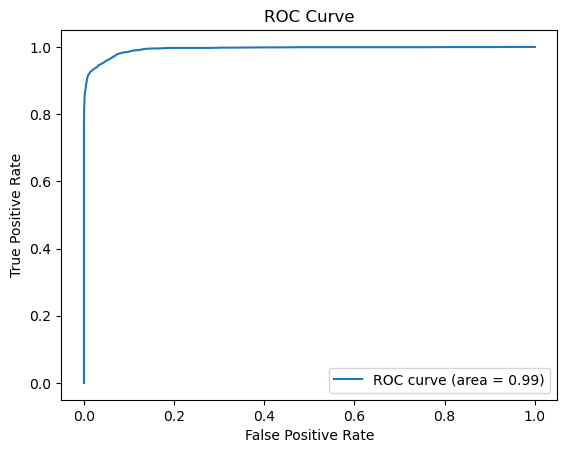

Threshold: 0.2
              precision    recall  f1-score   support

         0.0       1.00      0.76      0.87      8699
         1.0       0.53      1.00      0.70      2362

    accuracy                           0.81     11061
   macro avg       0.77      0.88      0.78     11061
weighted avg       0.90      0.81      0.83     11061

Threshold: 0.3
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93      8699
         1.0       0.67      0.99      0.80      2362

    accuracy                           0.89     11061
   macro avg       0.83      0.93      0.86     11061
weighted avg       0.93      0.89      0.90     11061

Threshold: 0.5
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96      8699
         1.0       0.81      0.97      0.88      2362

    accuracy                           0.95     11061
   macro avg       0.90      0.95      0.92     11061
weighted avg       0.95      

In [33]:
# 13.evaluar el modelo
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

#ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc}")

#curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.show()

thresholds_list = [0.2, 0.3, 0.5, 0.7]
for thresh in thresholds_list:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    print(f"Threshold: {thresh}")
    print(classification_report(y_test, y_pred_thresh))

#si queremos identificar a todos los morosos pero culpar a algunos no morosos(thresholds:0,3)
#si queremos identificar solo a reales morosos y evitar culpar a no morosos (threshols: 0,7)